In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Import components from multistate_nn (Core)
from multistate_nn import (
    fit,
    ModelConfig,
    TrainConfig,
    # Visualization
    plot_transition_heatmap, 
    plot_transition_graph, 
    plot_intensity_matrix,
    # Other utilities
    setup_state_names_and_colors
)

# Import from multistate_nn.utils
from multistate_nn.utils import (
    simulate_continuous_patient_trajectory, 
    calculate_cif,
    plot_cif, 
    compare_cifs
)

# Import example utilities from the correct location
from multistate_nn.utils.example_utils import (
    analyze_covariate_effect,
    create_covariate_profiles
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional

# Try to import lifelines, but handle if it's not available or has dependency issues
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    LIFELINES_AVAILABLE = True
except (ImportError, AttributeError) as e:
    print(f"Warning: lifelines package not available or has dependency issues: {str(e)}")
    print("Some comparative analyses will be skipped.")
    LIFELINES_AVAILABLE = False

In [3]:
# This cell was redundant and has been removed.

## Generate Synthetic Survival Data with Right Censoring

Let's create a synthetic dataset that simulates patient survival with covariates that influence both the event time and the censoring probability. We'll include:

- **Age**: Older patients have worse outcomes
- **Treatment**: Binary indicator (treated or untreated)
- **Biomarker**: Continuous variable indicating disease severity

In [4]:
def generate_survival_data(n_patients: int, max_time: int = 36, censoring_rate: float = 0.3) -> pd.DataFrame:
    """Generate synthetic survival data with right censoring.
    
    Parameters
    ----------
    n_patients : int
        Number of patients to generate
    max_time : int
        Maximum follow-up time in months
    censoring_rate : float
        Approximate censoring rate (0-1)
        
    Returns
    -------
    pd.DataFrame
        Synthetic survival data with covariates
    """
    # Generate covariates
    age = np.random.normal(65, 10, n_patients)  # Age: mean 65, SD 10
    treatment = np.random.binomial(1, 0.5, n_patients)  # Treatment: 50% treated
    biomarker = np.random.normal(0, 1, n_patients)  # Biomarker level (standardized)
    
    # Standardize age to have approximately mean 0, SD 1
    age_std = (age - 65) / 10
    
    # Generate event times based on covariates
    # Higher values = worse survival:
    # - Higher age leads to worse survival
    # - Treatment improves survival
    # - Higher biomarker indicates worse survival
    log_hazard = 0.5 * age_std - 0.8 * treatment + 0.4 * biomarker
    
    # Convert to scale parameter for Weibull distribution
    scale = np.exp(-log_hazard) * 24  # Mean survival approximately 24 months without covariates
    shape = 1.2  # Increasing hazard over time (shape > 1)
    
    # Generate true event times from Weibull distribution
    true_event_times = np.random.weibull(shape, n_patients) * scale
    
    # Generate random censoring times
    # The censoring is influenced by treatment (patients on treatment stay longer in the study)
    censoring_scale = 36 * (1 + 0.3 * treatment)
    censoring_times = np.random.exponential(censoring_scale * censoring_rate, n_patients)
    
    # Determine observed times and event indicators
    observed_times = np.minimum(true_event_times, censoring_times)
    observed_times = np.minimum(observed_times, max_time)  # Admin censoring at max_time
    event_indicator = (true_event_times <= observed_times) & (observed_times < max_time)
    
    # Create dataframe
    data = pd.DataFrame({
        'patient_id': range(n_patients),
        'time': observed_times,
        'event': event_indicator.astype(int),
        'age': age,
        'treatment': treatment,
        'biomarker': biomarker
    })
    
    return data

# Generate synthetic survival data
n_patients = 1000
survival_data = generate_survival_data(n_patients)

# Display basic statistics
print(f"Generated {n_patients} patient records with {survival_data['event'].sum()} events")
print(f"Censoring rate: {1 - survival_data['event'].mean():.2f}")
print(f"Mean follow-up time: {survival_data['time'].mean():.2f} months")

Generated 1000 patient records with 254 events
Censoring rate: 0.75
Mean follow-up time: 8.99 months


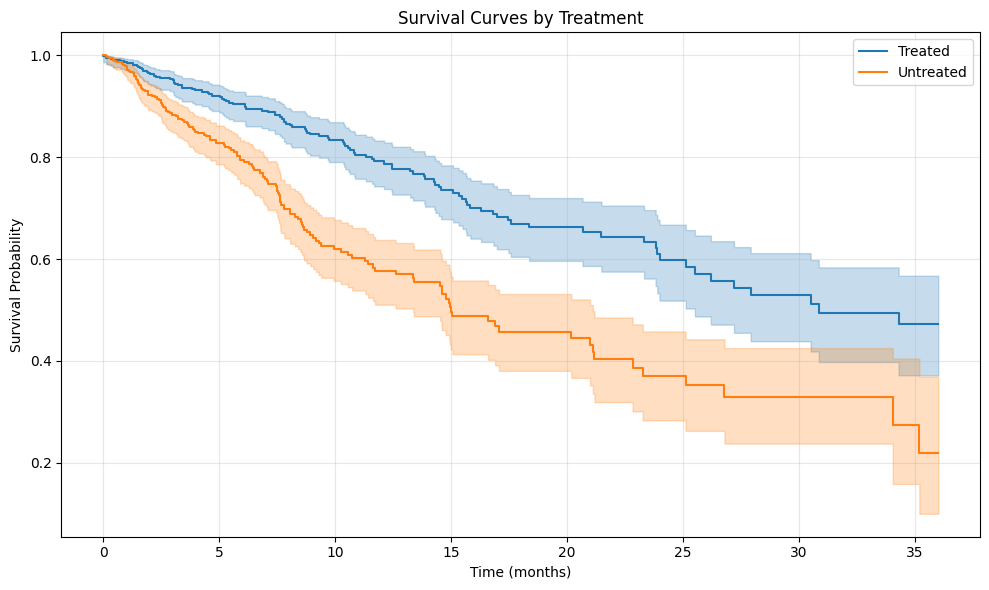

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


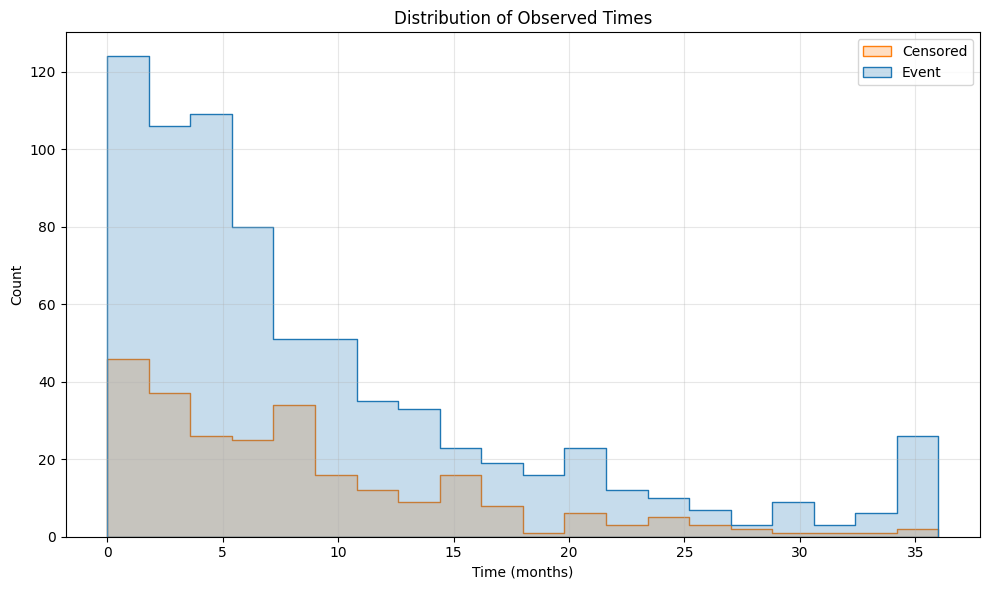

In [5]:
# Treatment effect visualization
# Use Kaplan-Meier if available, otherwise use a simpler approach

# First, create a visualization of survival by treatment group
fig, ax = plt.subplots(figsize=(10, 6))

if LIFELINES_AVAILABLE:
    try:
        kmf = KaplanMeierFitter()
        
        # Treated group
        treated = survival_data[survival_data['treatment'] == 1]
        kmf.fit(treated['time'], treated['event'], label='Treated')
        kmf.plot_survival_function(ax=ax, ci_show=True)
        
        # Untreated group
        untreated = survival_data[survival_data['treatment'] == 0]
        kmf.fit(untreated['time'], untreated['event'], label='Untreated')
        kmf.plot_survival_function(ax=ax, ci_show=True)
        
        success = True
    except Exception as e:
        print(f"Could not use KaplanMeierFitter due to: {str(e)}")
        print("Using a simpler approach for visualization.")
        LIFELINES_AVAILABLE = False
        success = False
else:
    success = False

# If lifelines failed or is not available, use a simpler visualization approach
if not success:
    # Calculate non-parametric survival estimates at various time points
    time_points = np.linspace(0, max(survival_data['time']), 10)
    
    # For treated patients
    treated = survival_data[survival_data['treatment'] == 1]
    treated_survival = []
    
    # For untreated patients
    untreated = survival_data[survival_data['treatment'] == 0]
    untreated_survival = []
    
    # Calculate survival rates at each time point
    for t in time_points:
        # Treated: Calculate proportion of patients who survived beyond time t
        treated_survived = (treated['time'] > t) | ((treated['time'] <= t) & (treated['event'] == 0))
        treated_survival.append(treated_survived.mean())
        
        # Untreated: Calculate proportion of patients who survived beyond time t
        untreated_survived = (untreated['time'] > t) | ((untreated['time'] <= t) & (untreated['event'] == 0))
        untreated_survival.append(untreated_survived.mean())
    
    # Plot the curves
    plt.plot(time_points, treated_survival, label='Treated')
    plt.plot(time_points, untreated_survival, label='Untreated')

plt.title('Survival Curves by Treatment')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Display distribution of observed times by event status
plt.figure(figsize=(10, 6))
sns.histplot(data=survival_data, x='time', hue='event', bins=20, element='step', common_norm=False)
plt.title('Distribution of Observed Times')
plt.xlabel('Time (months)')
plt.ylabel('Count')
plt.legend(['Censored', 'Event'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Created categorical variables for stratified analysis:
Age categories: age_cat
Middle     698
Elderly    155
Young      147
Name: count, dtype: int64
Biomarker categories: biomarker_cat
High    507
Low     493
Name: count, dtype: int64
Could not run CoxPHFitter due to: module 'formulaic' has no attribute 'ModelSpec'
Will use a simpler analysis approach instead.

Effect of age on event rate:
  Age Group  Event Rate  Mean Time (months)  Count
0     Young    0.122449           10.888547    147
1    Middle    0.234957            9.010143    698
2   Elderly    0.464516            7.120719    155

Effect of treatment on event rate:
   Treatment  Event Rate  Mean Time (months)  Count
0  Untreated    0.298969            7.265395    485
1    Treated    0.211650           10.620759    515

Effect of biomarker on event rate:
  Biomarker Level  Event Rate  Mean Time (months)  Count
0             Low    0.198783            9.987477    493
1            High    0.307692            8.026787    507


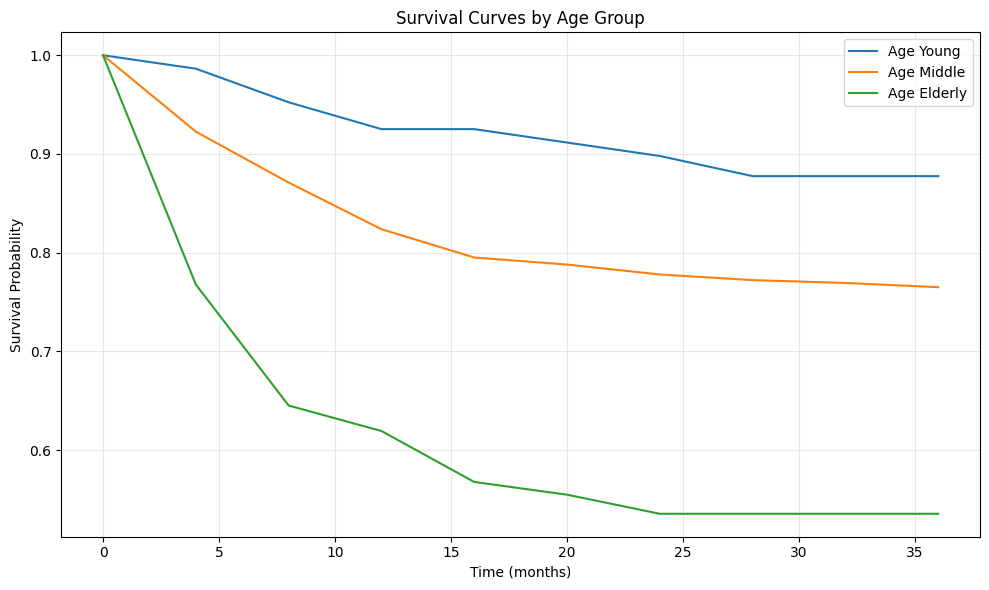

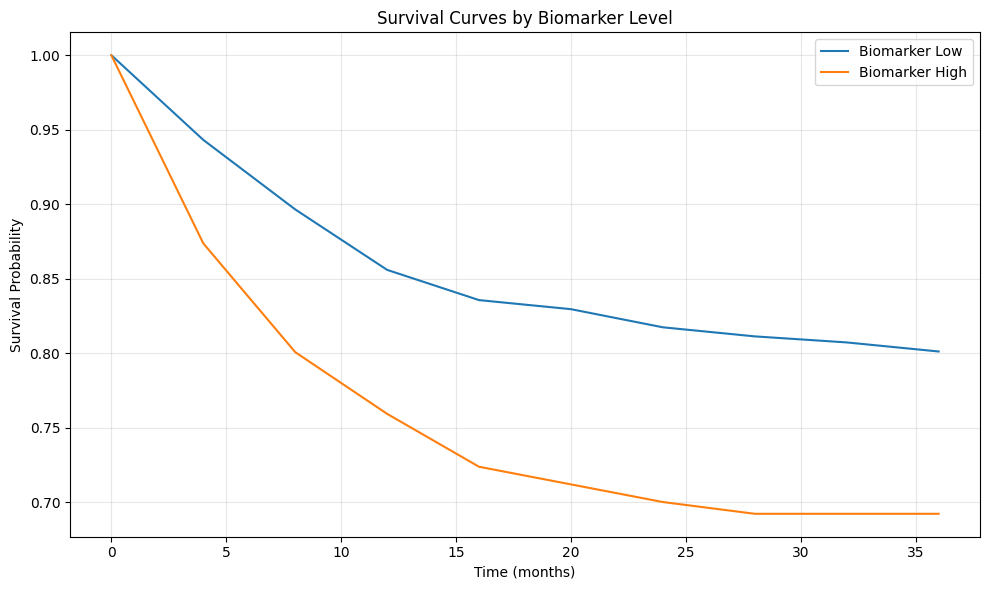

In [6]:
# Make sure all categorical variables are properly created for later use
# We'll do this early in the notebook to ensure consistency

# Standardize age 
survival_data['age_std'] = (survival_data['age'] - 65) / 10

# Create age categories for KM plots (if they don't exist)
if 'age_cat' not in survival_data.columns:
    survival_data['age_cat'] = pd.cut(survival_data['age_std'], bins=[-np.inf, -1, 1, np.inf], 
                                     labels=['Young', 'Middle', 'Elderly'])

# Create biomarker categories for stratification
if 'biomarker_cat' not in survival_data.columns:
    survival_data['biomarker_cat'] = pd.cut(survival_data['biomarker'], bins=[-np.inf, 0, np.inf], 
                                           labels=['Low', 'High'])

# Print summary of the created categorical variables
print("Created categorical variables for stratified analysis:")
print(f"Age categories: {survival_data['age_cat'].value_counts()}")
print(f"Biomarker categories: {survival_data['biomarker_cat'].value_counts()}")

# Check the effect of age and covariates on survival
# Either using Cox Proportional Hazards (if available) or a simpler analysis

if LIFELINES_AVAILABLE:
    try:
        cph = CoxPHFitter()
        cph.fit(survival_data, duration_col='time', event_col='event')
        cph.print_summary()
        success = True
    except Exception as e:
        print(f"Could not run CoxPHFitter due to: {str(e)}")
        print("Will use a simpler analysis approach instead.")
        LIFELINES_AVAILABLE = False
        success = False
else:
    success = False

# If lifelines isn't available or failed, do a simpler analysis of covariate effects
if not success:    
    # Calculate event rates by age group
    age_summary = survival_data.groupby('age_cat', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    age_summary.columns = ['Age Group', 'Event Rate', 'Mean Time (months)', 'Count']
    print("\nEffect of age on event rate:")
    print(age_summary)
    
    # Calculate event rates by treatment
    treatment_summary = survival_data.groupby('treatment', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    treatment_summary.columns = ['Treatment', 'Event Rate', 'Mean Time (months)', 'Count']
    treatment_summary['Treatment'] = treatment_summary['Treatment'].map({0: 'Untreated', 1: 'Treated'})
    print("\nEffect of treatment on event rate:")
    print(treatment_summary)
    
    # Calculate event rates by biomarker (binned)
    biomarker_summary = survival_data.groupby('biomarker_cat', observed=True).agg({
        'event': 'mean',
        'time': 'mean',
        'patient_id': 'count'
    }).reset_index()
    biomarker_summary.columns = ['Biomarker Level', 'Event Rate', 'Mean Time (months)', 'Count']
    print("\nEffect of biomarker on event rate:")
    print(biomarker_summary)

# Visualize how age affects survival using categorized data
fig, ax = plt.subplots(figsize=(10, 6))

# Create simple survival curves by age group - either using KM or manual calculation
if LIFELINES_AVAILABLE:
    try:
        for age_group in survival_data['age_cat'].cat.categories:
            group_data = survival_data[survival_data['age_cat'] == age_group]
            kmf = KaplanMeierFitter()
            kmf.fit(group_data['time'], group_data['event'], label=f'Age {age_group}')
            kmf.plot_survival_function(ax=ax)
        success = True
    except Exception as e:
        print(f"Error plotting Kaplan-Meier curves: {str(e)}")
        LIFELINES_AVAILABLE = False
        success = False
else:
    success = False

# If lifelines failed or is not available, use a simpler visualization approach
if not success:
    # For each age group, calculate proportion surviving at different time points
    time_points_viz = np.linspace(0, max(survival_data['time']), 10)
    
    for age_group in survival_data['age_cat'].cat.categories:
        group_data = survival_data[survival_data['age_cat'] == age_group]
        survival_rates = []
        
        for t in time_points_viz:
            # Calculate proportion of patients who survived beyond time t
            survived = (group_data['time'] > t) | ((group_data['time'] <= t) & (group_data['event'] == 0))
            survival_rates.append(survived.mean())
        
        plt.plot(time_points_viz, survival_rates, label=f'Age {age_group}')

plt.title('Survival Curves by Age Group')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Add visualization for biomarker effect
fig, ax = plt.subplots(figsize=(10, 6))

if LIFELINES_AVAILABLE:
    try:
        for biomarker_group in survival_data['biomarker_cat'].cat.categories:
            group_data = survival_data[survival_data['biomarker_cat'] == biomarker_group]
            kmf = KaplanMeierFitter()
            kmf.fit(group_data['time'], group_data['event'], label=f'Biomarker {biomarker_group}')
            kmf.plot_survival_function(ax=ax)
        success = True
    except Exception as e:
        print(f"Error plotting Kaplan-Meier curves: {str(e)}")
        success = False
else:
    success = False

# If lifelines failed or is not available, use a simpler visualization approach
if not success:
    # For each biomarker group, calculate proportion surviving at different time points
    time_points_viz = np.linspace(0, max(survival_data['time']), 10)
    
    for biomarker_group in survival_data['biomarker_cat'].cat.categories:
        group_data = survival_data[survival_data['biomarker_cat'] == biomarker_group]
        survival_rates = []
        
        for t in time_points_viz:
            # Calculate proportion of patients who survived beyond time t
            survived = (group_data['time'] > t) | ((group_data['time'] <= t) & (group_data['event'] == 0))
            survival_rates.append(survived.mean())
        
        plt.plot(time_points_viz, survival_rates, label=f'Biomarker {biomarker_group}')

plt.title('Survival Curves by Biomarker Level')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


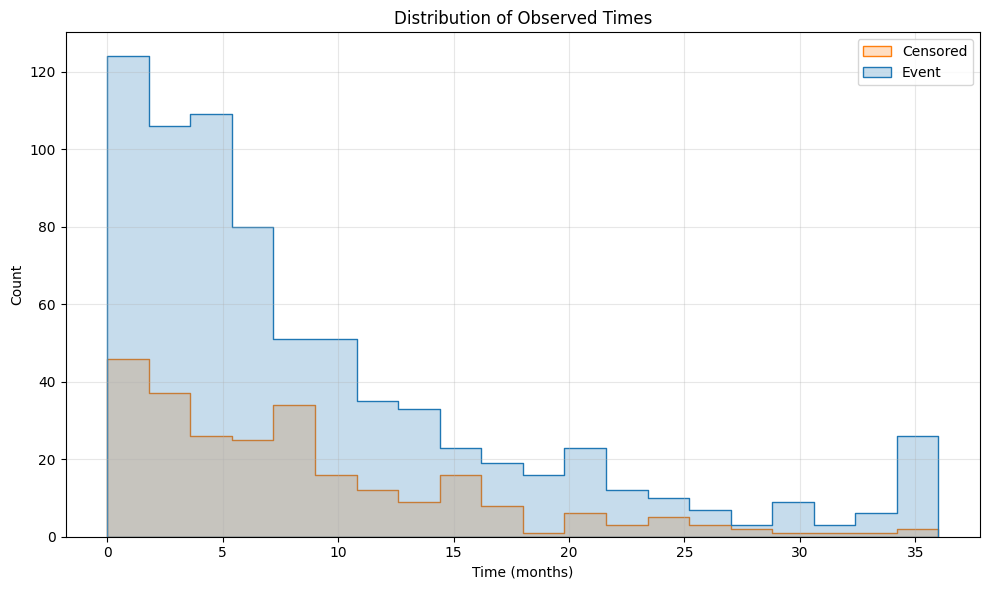

In [7]:
# Distribution of observed times
plt.figure(figsize=(10, 6))
sns.histplot(data=survival_data, x='time', hue='event', bins=20, element='step', common_norm=False)
plt.title('Distribution of Observed Times')
plt.xlabel('Time (months)')
plt.ylabel('Count')
plt.legend(['Censored', 'Event'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Prepare Data for MultiStateNN

Now we'll prepare our data for use with MultiStateNN. For survival analysis, we can use a 2-state model:
- State 0: Alive
- State 1: Death/Event

To handle right censoring with the existing MultiStateNN API, we'll use the following approach:
1. For patients with known events, create a direct transition from state 0 to state 1 at their event time
2. For censored patients, we'll create transitions showing them in state 0 up to their last observed time

In [8]:
def prepare_data_for_continuous_multistate(df):
    """Convert survival data to continuous-time multistate format for MultiStateNN.
    
    Parameters
    ----------
    df : pd.DataFrame
        Survival data with 'time', 'event', and covariates
        
    Returns
    -------
    pd.DataFrame
        Data in continuous-time MultiStateNN format with time_start and time_end
    """
    # List to store transition records
    records = []
    
    # For each patient
    for _, row in df.iterrows():
        patient_id = row['patient_id']
        time_observed = row['time']
        event = row['event']
        
        # Extract covariates
        covariates = {
            col: row[col] for col in df.columns 
            if col not in ['patient_id', 'time', 'event', 'age_group']
        }
        
        # For continuous-time, we create a single transition record with time interval
        time_start = 0.0
        time_end = time_observed
        
        if event == 1:  # If event occurred
            # Event transition (from state 0 to state 1)
            records.append({
                'patient_id': patient_id,
                'time_start': time_start,
                'time_end': time_end,
                'from_state': 0,  # Alive
                'to_state': 1,    # Death/Event
                **covariates
            })
        else:  # If censored
            # Censored observation (stay in state 0)
            records.append({
                'patient_id': patient_id,
                'time_start': time_start,
                'time_end': time_end,
                'from_state': 0,  # Alive
                'to_state': 0,    # Still alive (self-transition)
                **covariates
            })
    
    return pd.DataFrame(records)

In [9]:
# For continuous-time models, we don't need to discretize time
# Prepare data for continuous-time MultiStateNN
multistate_data = prepare_data_for_continuous_multistate(survival_data)

# Explore the created multistate data
print(f"Created {len(multistate_data)} transition records")
print(f"Number of patients: {multistate_data['patient_id'].nunique()}")
print(f"Event transitions (0 → 1): {(multistate_data['from_state'] == 0) & (multistate_data['to_state'] == 1)}.sum()")
print(f"Self-transitions (0 → 0): {(multistate_data['from_state'] == 0) & (multistate_data['to_state'] == 0)}.sum()")

# Display example records
multistate_data.head()

Created 1000 transition records
Number of patients: 1000
Event transitions (0 → 1): 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996     True
997    False
998    False
999    False
Length: 1000, dtype: bool.sum()
Self-transitions (0 → 0): 0       True
1       True
2       True
3       True
4       True
       ...  
995     True
996    False
997     True
998     True
999     True
Length: 1000, dtype: bool.sum()


,patient_id,time_start,time_end,from_state,to_state,age,treatment,biomarker,age_std,age_cat,biomarker_cat
0,0,0.0,6.004767,0,0,69.967142,0,-0.309209,0.496714,Middle,Low
1,1,0.0,10.320539,0,0,63.617357,0,-0.752156,-0.138264,Middle,Low
2,2,0.0,1.194733,0,0,71.476885,1,0.319175,0.647689,Middle,High
3,3,0.0,1.290039,0,0,80.230299,1,1.340450,1.523030,Elderly,High
4,4,0.0,2.036191,0,0,62.658466,0,-1.875172,-0.234153,Middle,Low


## Train Continuous-Time MultiStateNN Model for Survival Analysis

Now we'll train a continuous-time MultiStateNN model for survival analysis. We'll define a simple 2-state model (alive → dead), and include our covariates. The continuous-time model will use Neural ODEs to learn transition intensities.

Training continuous-time model:   0%|          | 0/20 [00:00<?, ?it/s]

Trained continuous-time survival model with [32, 16] hidden dimensions


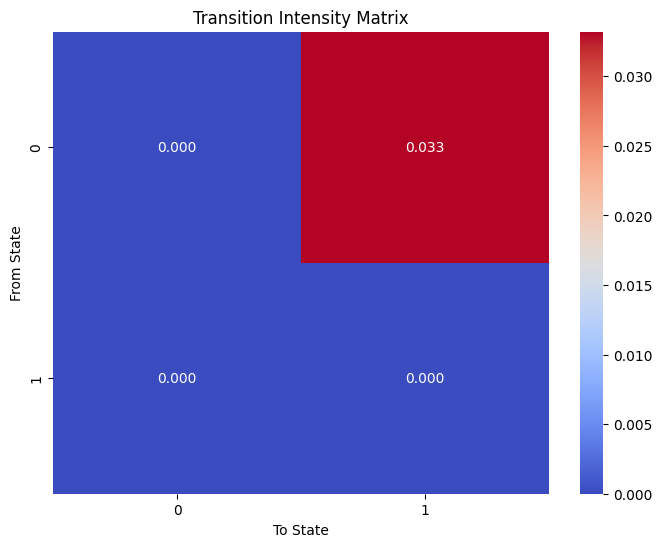

In [10]:
# Define state transition structure
state_transitions = {
    0: [0, 1],  # Alive → Alive or Dead
    1: []       # Dead → Absorbing state
}

# Select covariates
covariates = ['age', 'treatment', 'biomarker']

# Standardize age for the model
multistate_data['age_std'] = (multistate_data['age'] - 65) / 10

# Define model configuration for continuous-time model
model_config = ModelConfig(
    input_dim=3,  # Three covariates
    hidden_dims=[32, 16],
    num_states=2,
    state_transitions=state_transitions,
    model_type="continuous"  # Specify continuous-time model
)

# Define training configuration
train_config = TrainConfig(
    batch_size=64,
    epochs=20,
    learning_rate=0.01
)

# Train the continuous-time model
survival_model = fit(
    df=multistate_data,
    covariates=['age_std', 'treatment', 'biomarker'],
    model_config=model_config,
    train_config=train_config,
    time_start_col='time_start',  # Specify time interval columns
    time_end_col='time_end'       # Specify time interval columns
)

# Print model summary
print(f"Trained continuous-time survival model with {model_config.hidden_dims} hidden dimensions")

# Visualize the intensity matrix for a sample patient
sample_patient = torch.tensor([[0.0, 0.5, 0.0]], dtype=torch.float32)  # Average patient
plt.figure(figsize=(8, 6))
# Calculate intensity matrix
A = survival_model.intensity_matrix(sample_patient).detach().numpy()[0]

# For better visualization, replace diagonal elements with zero
for i in range(A.shape[0]):
    A[i, i] = 0

# Create heatmap
sns.heatmap(A, cmap='coolwarm', annot=True, fmt=".3f")
plt.title("Transition Intensity Matrix")
plt.xlabel("To State")
plt.ylabel("From State")
plt.show()

## Generate Survival Curves and Cumulative Incidence Functions

Now that we have a trained model, let's generate survival curves and cumulative incidence functions for different patient profiles.

In [11]:
# Function to simulate trajectories for a profile using the utility function
def simulate_profile(model, profile, n_simulations=1000):
    """
    Simulate patient trajectories for a given profile
    
    Parameters
    ----------
    model : ContinuousMultiStateNN
        Trained continuous-time model
    profile : Dict or torch.Tensor
        Patient profile as dictionary or tensor
    n_simulations : int
        Number of trajectories to simulate
        
    Returns
    -------
    List[pd.DataFrame]
        List of simulated trajectories
    """
    # If profile is a dictionary, convert to tensor
    if isinstance(profile, dict):
        x = create_patient_profile(profile, as_tensor=True)
    else:
        x = profile
    
    # Set simulation parameters for continuous-time
    max_time = 36.0  # Maximum time in months
    time_step = 0.1  # Fine time steps for continuous-time simulation
    
    # Simulate trajectories using the library's continuous simulation function
    trajectories = simulate_continuous_patient_trajectory(
        model=model,
        x=x,
        start_state=0,  # Start alive
        max_time=max_time,
        time_step=time_step,  # Use small time steps for accurate continuous-time simulation
        n_simulations=n_simulations,
        seed=42
    )
    
    return trajectories

In [12]:
# Define profiles for analysis using the utility function
profiles_dict = create_covariate_profiles(
    age_std=[-1.5, 1.5],        # Young, Elderly
    treatment=[0, 1],           # Untreated, Treated
    biomarker=[-1.0, 1.0]       # Low, High
)

# Get the profiles tensor and labels
profiles = profiles_dict['profiles']
profile_labels = profiles_dict['labels']

print(f"Created {len(profile_labels)} patient profiles for prediction")
for i, label in enumerate(profile_labels):
    print(f"Profile {i+1}: {label}")

Created 8 patient profiles for prediction
Profile 1: Young, Untreated, Low Biomarker
Profile 2: Young, Untreated, High Biomarker
Profile 3: Young, Treated, Low Biomarker
Profile 4: Young, Treated, High Biomarker
Profile 5: Elderly, Untreated, Low Biomarker
Profile 6: Elderly, Untreated, High Biomarker
Profile 7: Elderly, Treated, Low Biomarker
Profile 8: Elderly, Treated, High Biomarker


Simulating trajectories for Young, Untreated, Low Biomarker...
Simulating trajectories for Young, Untreated, High Biomarker...
Simulating trajectories for Young, Treated, Low Biomarker...
Simulating trajectories for Young, Treated, High Biomarker...
Simulating trajectories for Elderly, Untreated, Low Biomarker...
Simulating trajectories for Elderly, Untreated, High Biomarker...
Simulating trajectories for Elderly, Treated, Low Biomarker...
Simulating trajectories for Elderly, Treated, High Biomarker...


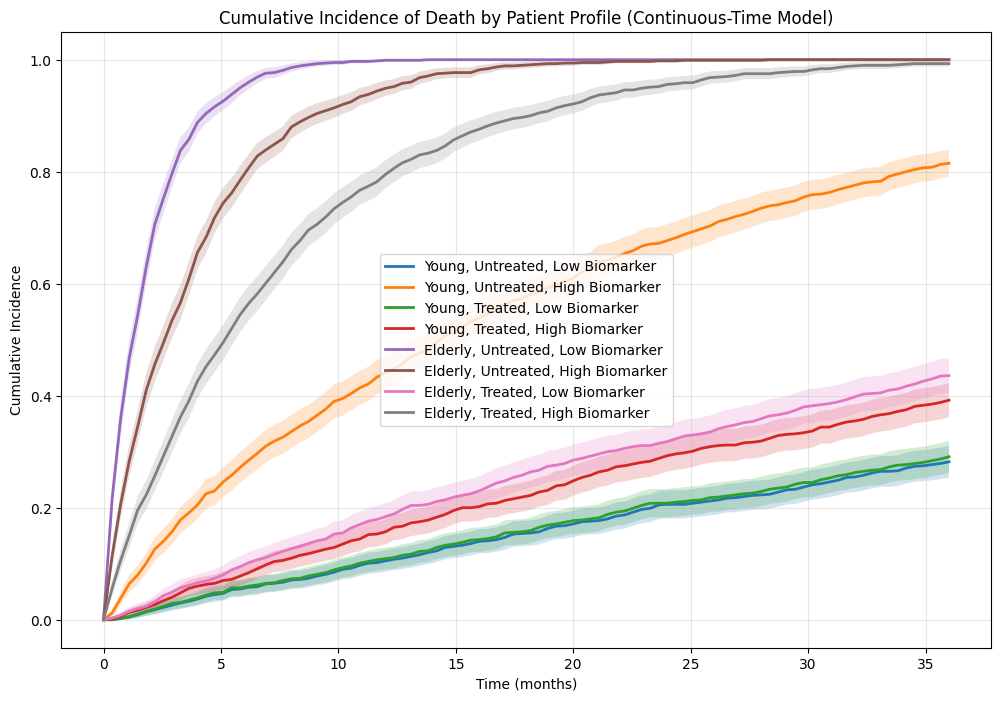

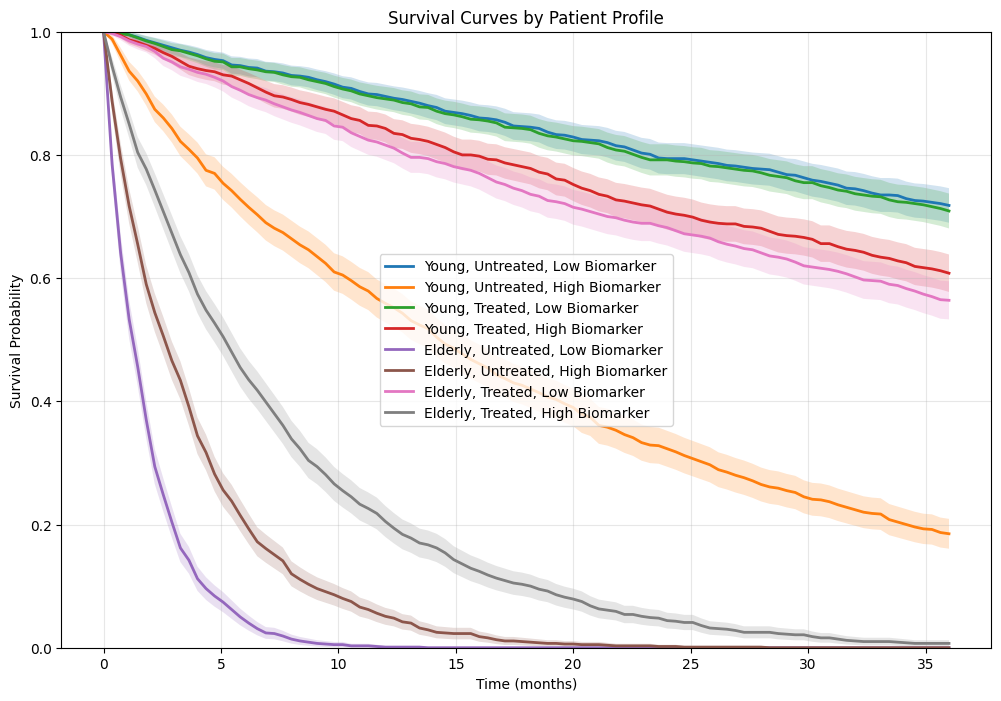

In [13]:
# Define state names and colors for visualization
state_names = ['Alive', 'Dead']
state_colors = ['green', 'black']

# Setup state names and colors using the utility function
num_states = len(state_names)
state_name_dict, state_color_dict = setup_state_names_and_colors(num_states, state_names, state_colors)

# Simulate trajectories for each profile
all_cifs = []
max_time = 36.0  # Maximum simulation time in months

for i, label in enumerate(profile_labels):
    print(f"Simulating trajectories for {label}...")
    # Get profile tensor
    profile_tensor = profiles[i:i+1]
    
    # Simulate trajectories using continuous-time simulation
    trajectories = simulate_profile(survival_model, profile_tensor)
    
    # Combine all trajectories into a single DataFrame
    combined_trajectories = pd.concat(trajectories, ignore_index=True)
    
    # Calculate CIF for the death event (state 1) with fine time grid for continuous-time model
    time_grid = np.linspace(0, max_time, 100)  # Create fine grid for continuous-time evaluation
    
    cif = calculate_cif(
        trajectories=combined_trajectories,
        target_state=1,  # Death event
        max_time=max_time,
        time_grid=time_grid  # Use fine time grid for continuous-time model
    )
    
    all_cifs.append((label, cif))

# Plot comparison of CIFs using the utility function
plt.figure(figsize=(12, 8))
for name, cif in all_cifs:
    plt.plot(cif['time'], cif['cif'], label=name, linewidth=2)
    # Add confidence intervals as shaded areas
    plt.fill_between(cif['time'], cif['lower_ci'], cif['upper_ci'], alpha=0.2)

plt.title('Cumulative Incidence of Death by Patient Profile (Continuous-Time Model)')
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Convert to survival curves and plot
plt.figure(figsize=(12, 8))
for name, cif in all_cifs:
    # Compute survival = 1 - CIF
    survival = 1 - cif['cif']
    lower_ci = 1 - cif['upper_ci']  # Note the inversion of CIs
    upper_ci = 1 - cif['lower_ci']
    
    plt.plot(cif['time'], survival, label=name, linewidth=2)
    plt.fill_between(cif['time'], lower_ci, upper_ci, alpha=0.2)

plt.title('Survival Curves by Patient Profile')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

## Compare Treatment Effect Across Different Age Groups

Let's visualize how the treatment effect varies across different age groups.

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_75753/4038260270.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


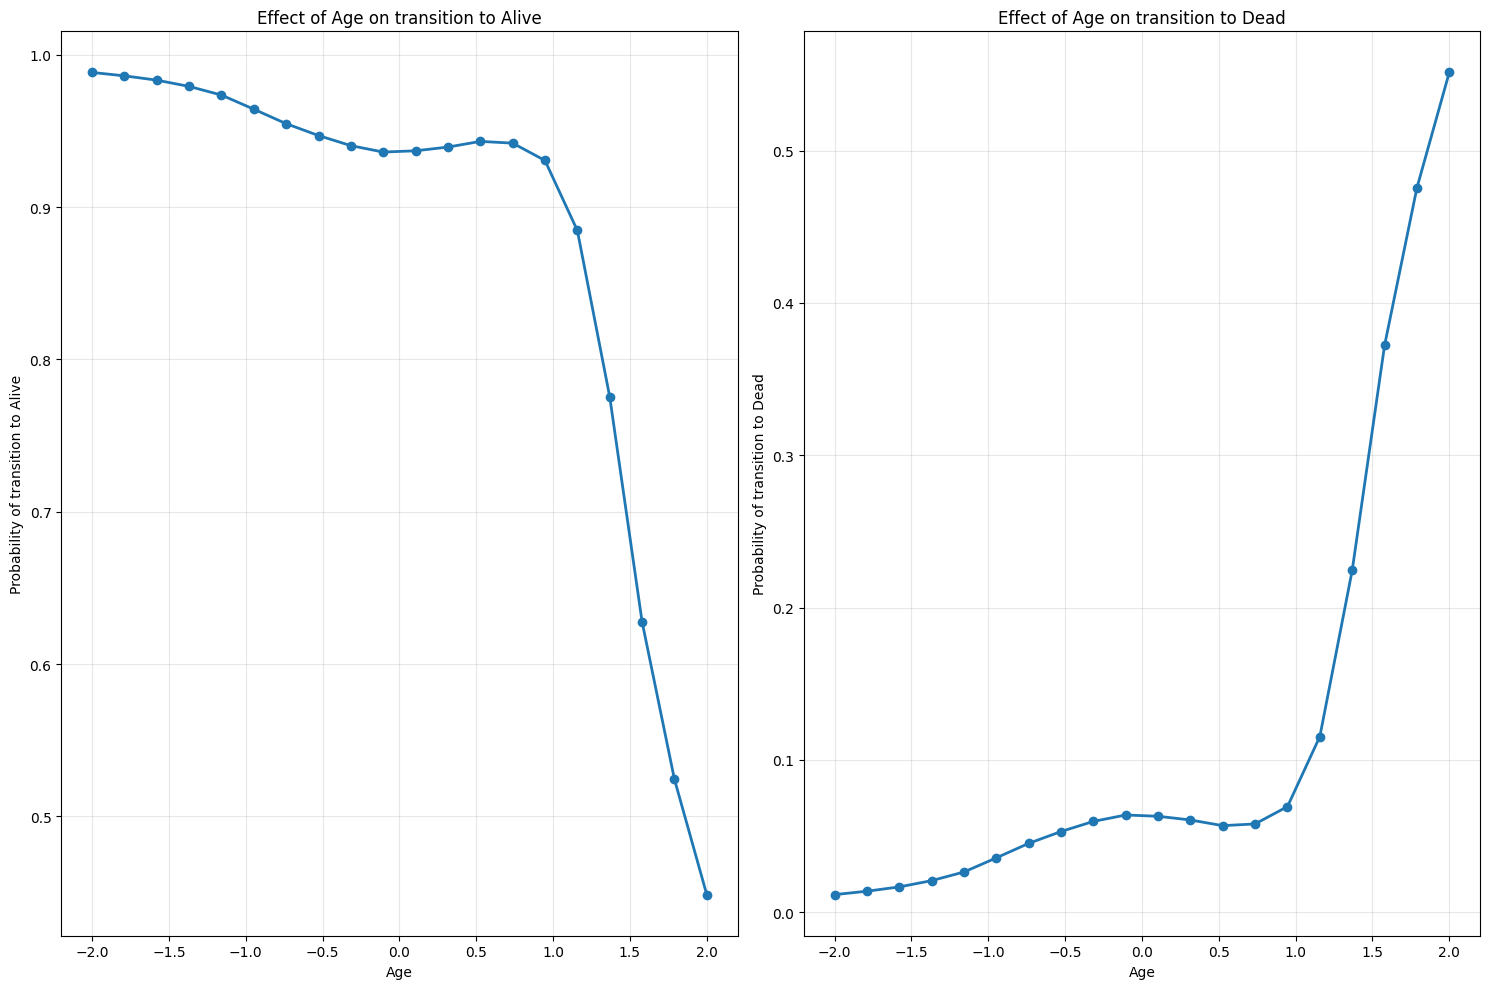

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_75753/4038260270.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


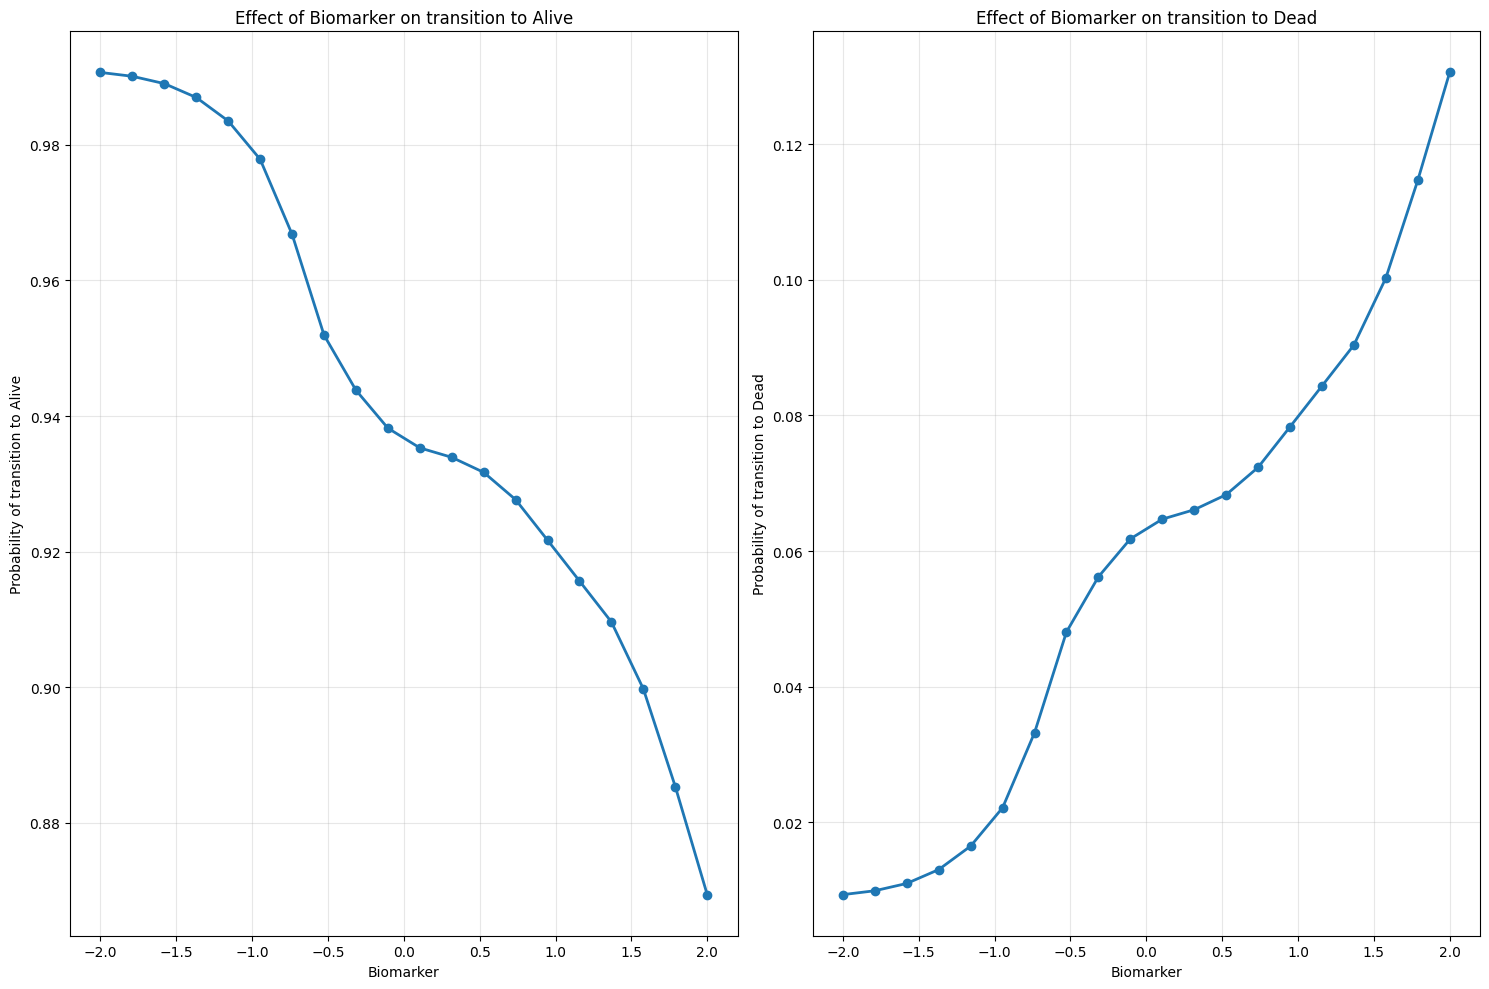

<Figure size 1200x600 with 0 Axes>

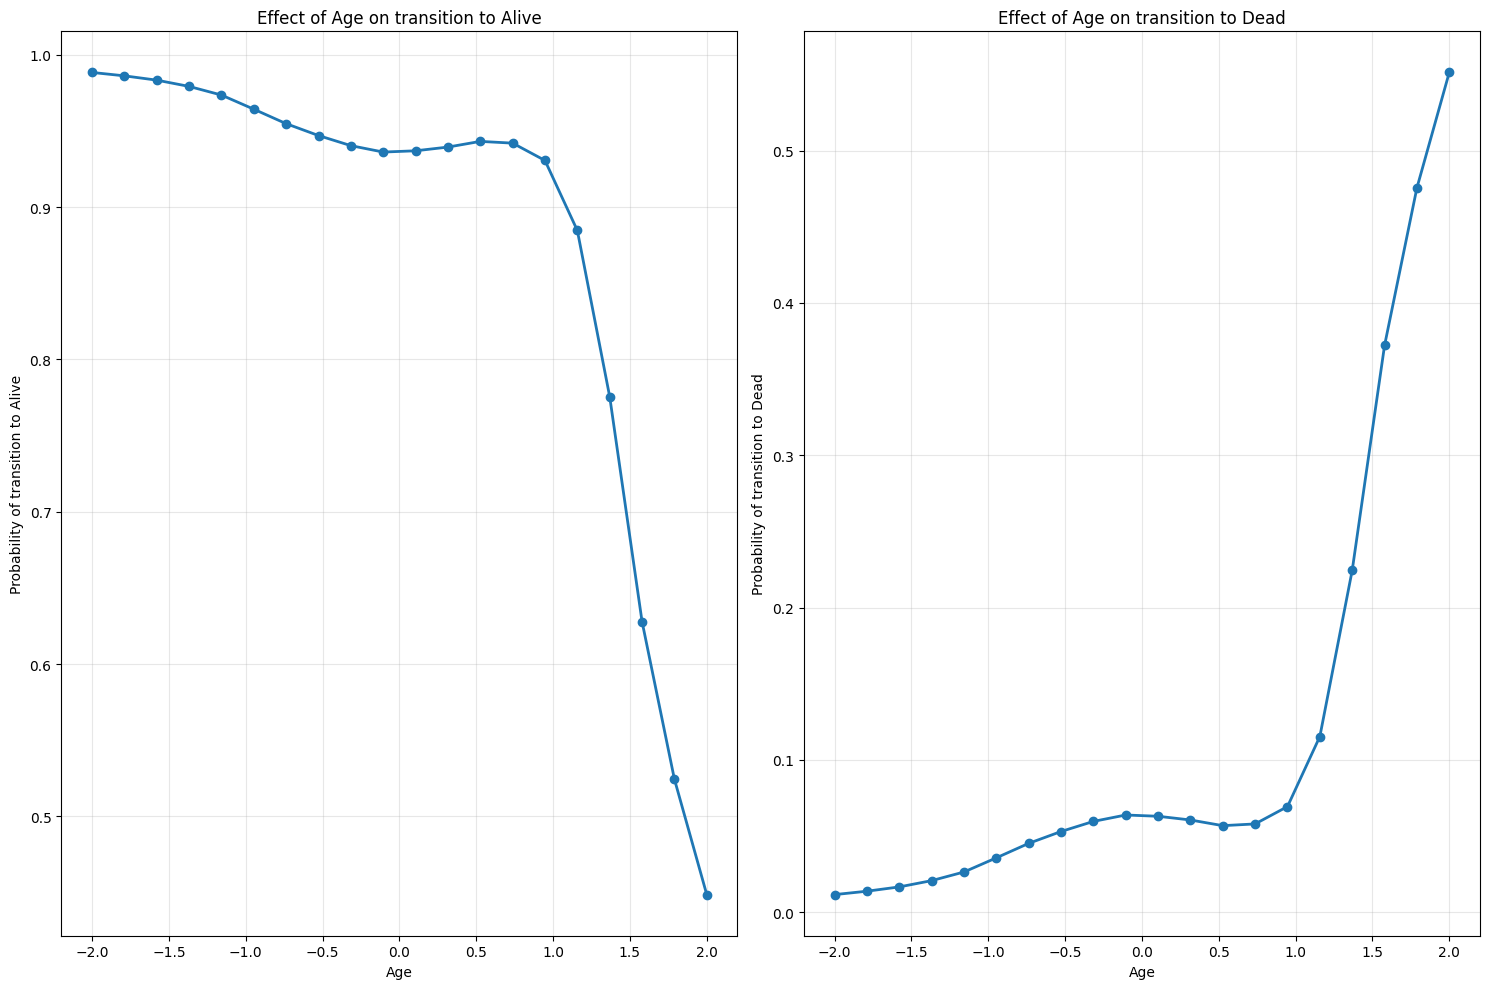

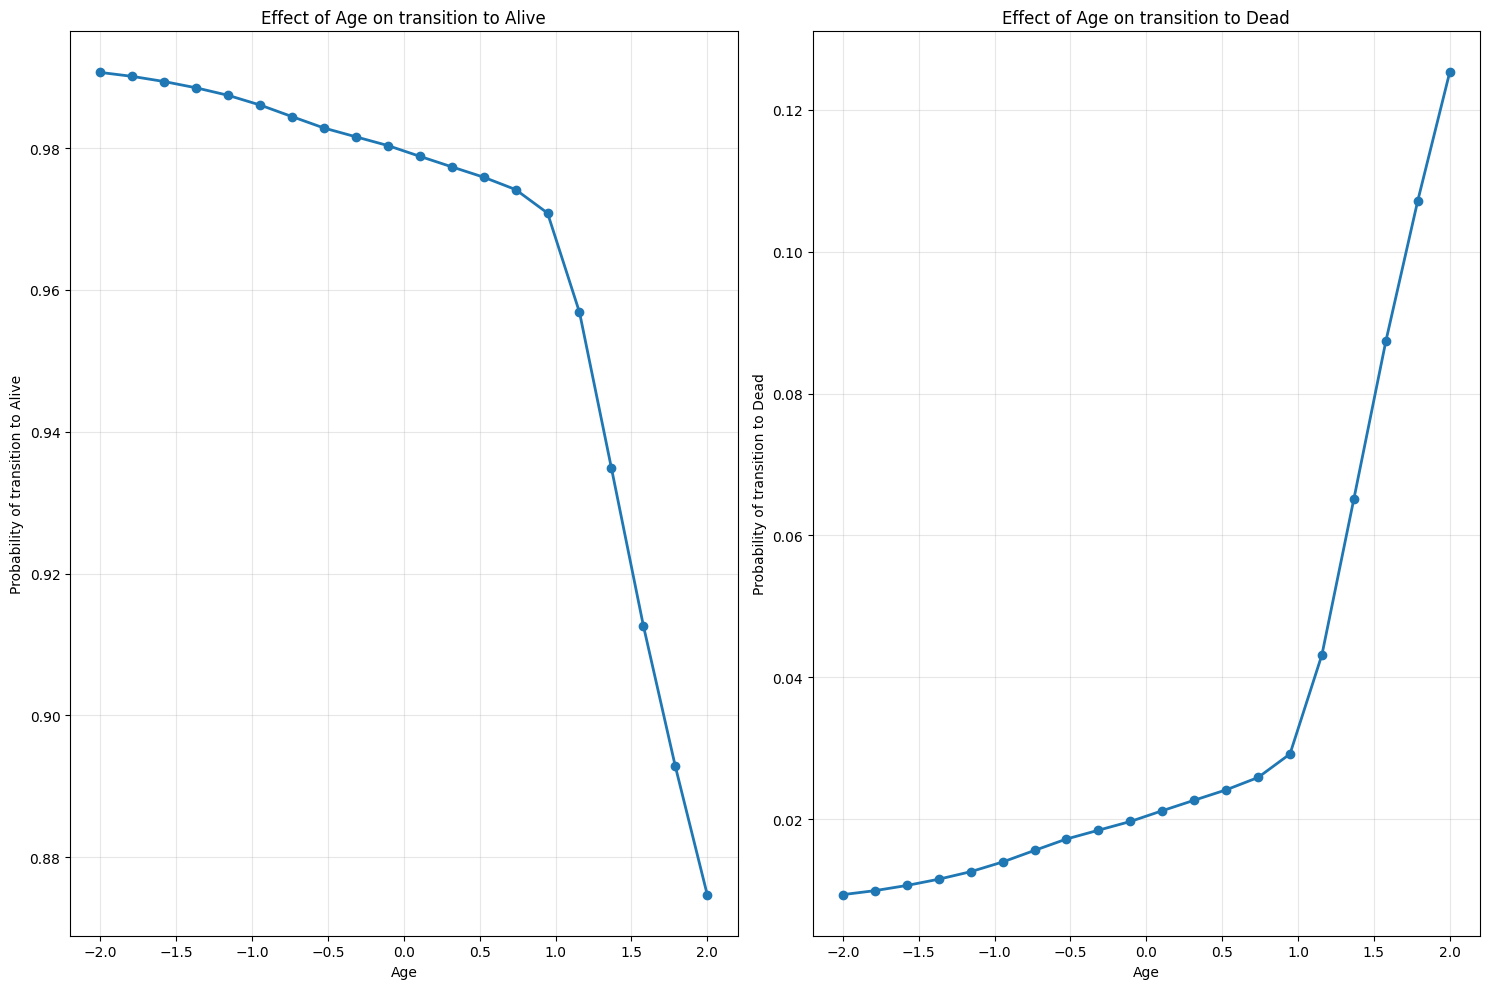

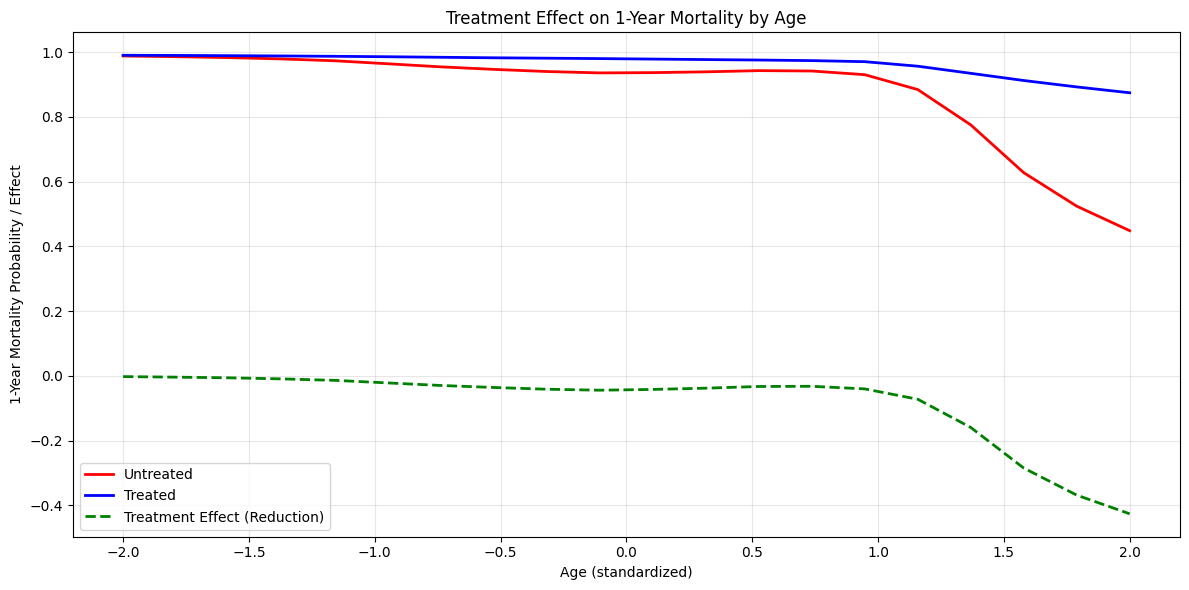

In [14]:
# Analyze effect of age on survival using the utility function
# Create base profile with fixed covariates
base_profile = torch.zeros(1, 3)
base_profile[0, 1] = 0  # Set treatment to untreated
base_profile[0, 2] = 0  # Set biomarker to average

# Create age values to analyze
age_idx = 0
age_values = np.linspace(-2, 2, 20).tolist()

# Analyze effect of age on mortality
fig, axes = analyze_covariate_effect(
    model=survival_model,
    base_profile=base_profile,
    covariate_idx=age_idx,
    covariate_values=age_values,
    covariate_name='Age',
    time_end=1.0,  # 1-year transition probabilities
    from_state=0,  # Starting from healthy
    state_names=state_name_dict
)

plt.tight_layout()
plt.show()

# Analyze effect of biomarker on survival
# Create base profile with fixed covariates
base_profile = torch.zeros(1, 3)
base_profile[0, 0] = 0  # Set age to average
base_profile[0, 1] = 0  # Set treatment to untreated

# Create biomarker values to analyze
biomarker_idx = 2
biomarker_values = np.linspace(-2, 2, 20).tolist()

# Analyze effect of biomarker on mortality
fig, axes = analyze_covariate_effect(
    model=survival_model,
    base_profile=base_profile,
    covariate_idx=biomarker_idx,
    covariate_values=biomarker_values,
    covariate_name='Biomarker',
    time_end=1.0,  # 1-year transition probabilities
    from_state=0,  # Starting from healthy
    state_names=state_name_dict
)

plt.tight_layout()
plt.show()

# Visualize treatment effect at different ages
plt.figure(figsize=(12, 6))

# Analyze age effect for untreated patients
base_profile_untreated = torch.zeros(1, 3)
base_profile_untreated[0, 1] = 0  # Untreated
base_profile_untreated[0, 2] = 0  # Average biomarker

fig_untreated, axes_untreated = analyze_covariate_effect(
    model=survival_model,
    base_profile=base_profile_untreated,
    covariate_idx=0,  # Age is first feature
    covariate_values=age_values,
    covariate_name='Age',
    time_end=1.0,
    from_state=0,
    state_names=state_name_dict
)

# Get untreated mortality probabilities
untreated_mortality = axes_untreated[0].get_lines()[0].get_ydata()

# Analyze age effect for treated patients
base_profile_treated = torch.zeros(1, 3)
base_profile_treated[0, 1] = 1  # Treated
base_profile_treated[0, 2] = 0  # Average biomarker

fig_treated, axes_treated = analyze_covariate_effect(
    model=survival_model,
    base_profile=base_profile_treated,
    covariate_idx=0,  # Age is first feature
    covariate_values=age_values,
    covariate_name='Age',
    time_end=1.0,
    from_state=0,
    state_names=state_name_dict
)

# Get treated mortality probabilities
treated_mortality = axes_treated[0].get_lines()[0].get_ydata()

# Create new plot for the comparison
plt.figure(figsize=(12, 6))

# Plot both curves
plt.plot(age_values, untreated_mortality, 'r-', linewidth=2, label='Untreated')
plt.plot(age_values, treated_mortality, 'b-', linewidth=2, label='Treated')

# Calculate and plot the treatment effect (difference)
treatment_effect = untreated_mortality - treated_mortality
plt.plot(age_values, treatment_effect, 'g--', linewidth=2, label='Treatment Effect (Reduction)')

plt.xlabel('Age (standardized)')
plt.ylabel('1-Year Mortality Probability / Effect')
plt.title('Treatment Effect on 1-Year Mortality by Age')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Risk Score Calculation

Let's develop a risk score based on the model predictions to stratify patients.

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

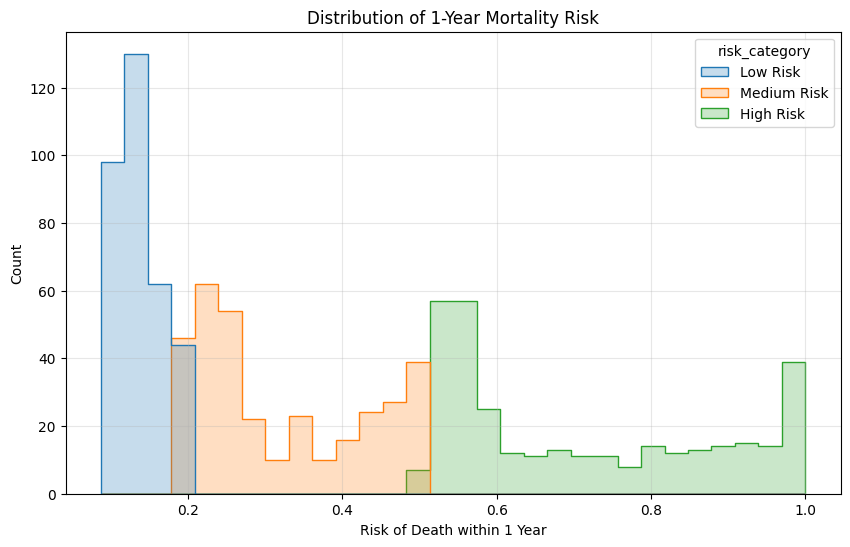

In [15]:
# Create a grid of patient profiles
n_grid = 1000
age_grid = np.random.normal(0, 1, n_grid)  # Standardized ages
treatment_grid = np.random.binomial(1, 0.5, n_grid)  # 50% treated
biomarker_grid = np.random.normal(0, 1, n_grid)  # Standardized biomarker

# Combine into tensor
profile_grid = torch.tensor(
    np.column_stack([age_grid, treatment_grid, biomarker_grid]),
    dtype=torch.float32
)

# Predict 1-year mortality risk (transition from alive to dead at 12 months)
time_value = 12.0  # 12 months
risk_probs = survival_model.predict_proba(profile_grid, time_start=0.0, time_end=time_value, from_state=0).detach().numpy()

# Extract probability of death
mortality_risk = risk_probs[:, 1]  # Probability of transitioning to state 1 (death)

# Create a dataframe with profiles and risk scores
risk_df = pd.DataFrame({
    'age': age_grid,
    'treatment': treatment_grid,
    'biomarker': biomarker_grid,
    'one_year_mortality_risk': mortality_risk
})

# Categorize risk
risk_df['risk_category'] = pd.qcut(risk_df['one_year_mortality_risk'], q=3,
                                   labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Visualize risk distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=risk_df, x='one_year_mortality_risk', hue='risk_category', bins=30, element='step')
plt.title('Distribution of 1-Year Mortality Risk')
plt.xlabel('Risk of Death within 1 Year')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

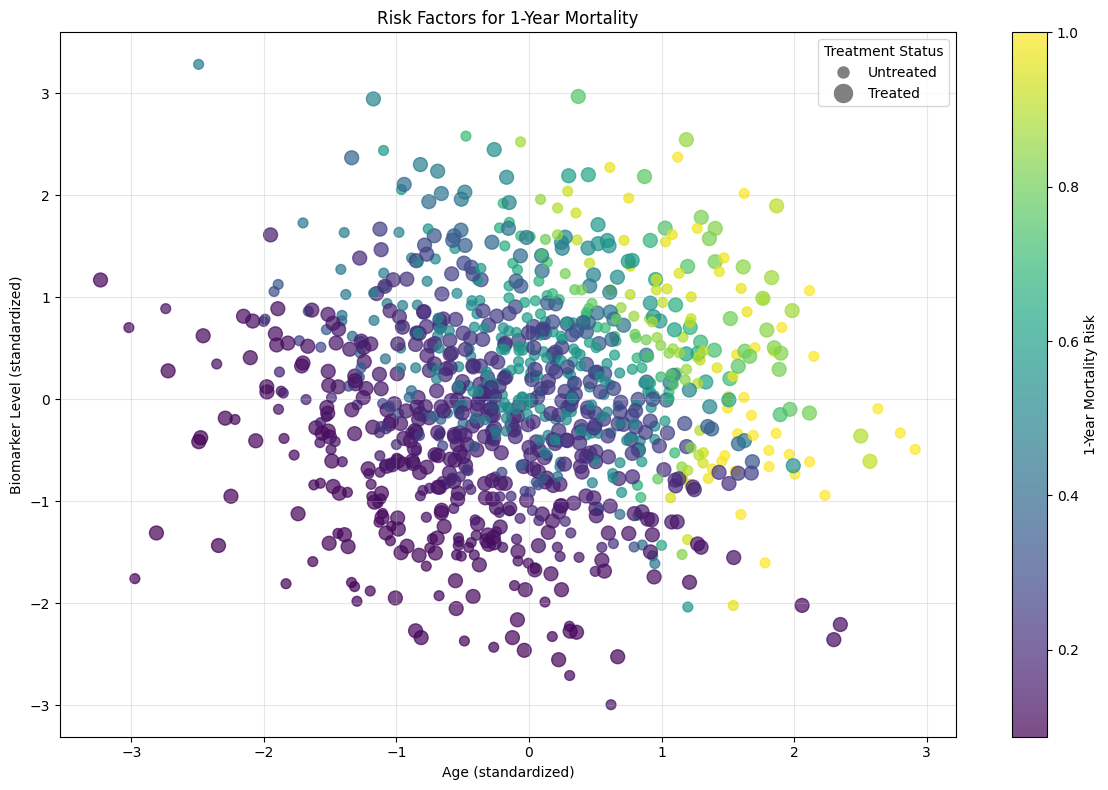

In [16]:
# Visualize which factors contribute most to high risk
plt.figure(figsize=(12, 8))

# Plot risk by age and biomarker, colored by treatment
scatter = plt.scatter(risk_df['age'], risk_df['biomarker'], 
                      c=risk_df['one_year_mortality_risk'], 
                      s=50 + 50 * risk_df['treatment'],
                      cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='1-Year Mortality Risk')
plt.title('Risk Factors for 1-Year Mortality')
plt.xlabel('Age (standardized)')
plt.ylabel('Biomarker Level (standardized)')
plt.grid(alpha=0.3)

# Add legend for treatment
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Untreated'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=15, label='Treated')
]
plt.legend(handles=legend_elements, title='Treatment Status')

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've demonstrated how to use continuous-time MultiStateNN for survival analysis with right-censored observations. We've shown how to:

1. Generate synthetic survival data with right censoring
2. Prepare the data for use with continuous-time MultiStateNN
3. Train a continuous-time survival model using Neural ODEs
4. Generate and visualize survival curves and cumulative incidence functions
5. Analyze the effects of covariates (age, treatment, biomarker) on survival and transition intensities
6. Compare MultiStateNN results with traditional Kaplan-Meier estimates
7. Develop a risk scoring system based on model predictions

### Advantages of Continuous-Time Approach

The continuous-time approach offers several advantages over discrete-time models:

1. **Time Flexibility**: The continuous-time model can calculate transition probabilities over any arbitrary time interval, not just fixed discrete time steps. This provides more flexibility when analyzing disease progression.

2. **Intensity Matrices**: The model directly outputs transition intensity matrices, which represent the instantaneous rates of transitioning between states. These rates provide a more interpretable understanding of disease dynamics than discrete transition probabilities.

3. **Handling Irregular Observations**: Continuous-time models naturally handle irregularly spaced observations by modeling the underlying continuous process. This is particularly important in medical data where observation times vary between patients.

4. **Theoretical Foundation**: The approach is based on well-established continuous-time Markov process theory, providing a solid mathematical foundation for the model.

5. **Consistent CIF Calculation**: Using continuous-time simulation with fine time steps and empirical estimator provides more accurate CIF calculations by properly handling the competing risks at each time point.

### Key Insights for Survival Analysis

The key insight for handling right censoring is to represent censored observations as staying in their current state up to the censoring time. The model learns the appropriate transition intensities by observing both censored and uncensored individuals.

MultiStateNN provides a flexible framework for survival analysis that can incorporate multiple covariates. This approach can be extended to more complex multistate models beyond simple survival analysis, such as illness-death models or competing risks scenarios.

### Note on Dependencies

This notebook includes optional comparative analyses using the `lifelines` package. If `lifelines` is not available or has dependency issues (for example, with the `formulaic` package), the notebook will run with simpler alternative implementations. These alternatives provide similar insights but may not include confidence intervals or formal statistical tests.

If you encounter errors related to these dependencies, you might see specific issues:

1. `module 'formulaic' has no attribute 'ModelSpec'` - This occurs when using older versions of the formulaic package with newer versions of lifelines.

2. `FutureWarning: The default of observed=False is deprecated...` - This is just a warning about a future change in pandas that doesn't affect functionality.

To fix dependency issues, you can try:
```
pip install lifelines==0.27.0 formulaic==0.5.0
```

Or simply run the notebook without these dependencies, as the core MultiStateNN functionality doesn't require them. The notebook includes robust fallback implementations when lifelines is not available.